In [1]:
using Distributions, ForwardDiff, Plots, LinearAlgebra, Images

# Model Specification

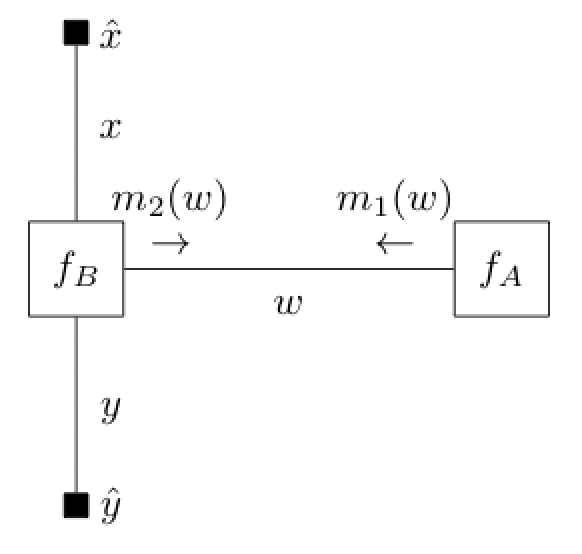

In [2]:
img = load("BLR.png")

$$
\begin{align*}
    f_A(w) &= \mathcal{N}(w;\mu_0,\sigma_0^{2}) \\
    f_B(y,x,w) &= \mathcal{BE}(y;\sigma(w^{T}x))
\end{align*}
$$

## Incoming messages

We apply online inference. For each data point, approximated posterior of $w$ becomes the prior for the next data point.

$$
\begin{align*}
    m_1(w) &= \frac{1}{\sqrt{2\pi}\sigma_0}\exp\left( -\frac{(w-\mu_0)^{2}}{2\sigma_0^{2}} \right) \\
    m_2(w) &= \sigma(w^{T}\hat{x})^{\hat{y}} (1 - \sigma(w^{T}\hat{x}))^{(1-\hat{y})}
\end{align*}
$$

# Synthetic Data

In [5]:
# Generate data
N = 100 #Number of data points
w_real = [4.5; -3.5]
x_dict = Dict()
y_dict = Dict()
for i=1:N
    x_i = rand(MvNormal([0.; 0.], [3.  0.0; 0.0 2.]))
    get!(x_dict, i, x_i)
    z_i = transpose(w_real)*x_i
    p_i = 1.0/(1.0 + exp(-1*z_i))
    y_i = 1.0*rand(Bernoulli(p_i))
    #y_i = round(p_i)
    get!(y_dict, i, y_i)
end

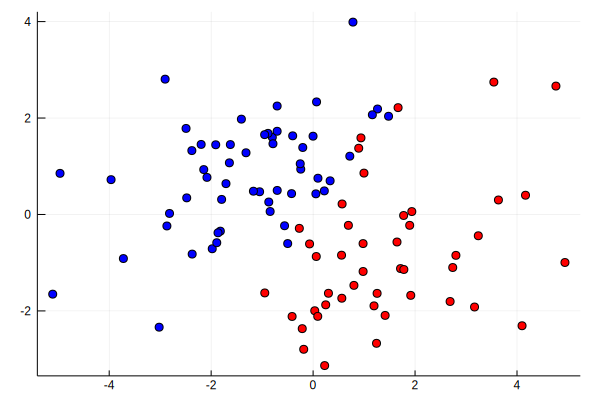

In [6]:
s = plot(leg=false)
for i=1:N
    if y_dict[i] == 0
        scatter!([x_dict[i][1]],[x_dict[i][2]],color="blue")
    else
        scatter!([x_dict[i][1]],[x_dict[i][2]],color="red")
    end
end
display(s)

# Model Construction

In [7]:
function fA(w,m0,s0)
    return pdf(MvNormal(m0,s0),w)
end

fA (generic function with 1 method)

In [8]:
function sigmoid(a)
    return 1.0/(1.0+exp(-1.0*a))
end

sigmoid (generic function with 1 method)

In [9]:
function fB(w,x,y)
    return pdf(Bernoulli(sigmoid(transpose(w)*x)),y)
end

fB (generic function with 1 method)

# Inference

In [10]:
free_energy_gaussian(m1,C1,m2,C2) = -log(2*pi) - log(sqrt(det(C2))) - (tr(inv(C2)*(C1+m1*transpose(m1))) - 2*(transpose(m1)*inv(C2)*m2) + transpose(m2)*inv(C2)*m2)/2

free_energy_gaussian (generic function with 1 method)

In [11]:
#Reparameterization function for Gaussian
function g(eps,a,b)
    return a + b*eps
end

g (generic function with 1 method)

In [12]:
nu_a = 0.05 #step size for mean optimization(much more smaller than the first example to prevent the problem with exploding gradient)
nu_b = 0.05 #step size for variance optimization
a_t, b_t = [0.; 0.], Diagonal(ones(2,2)) * sqrt(20.) #initial mean and variance values
free_energy_list = zeros(0)
a_t_dict, b_t_dict = Dict(0 => a_t), Dict(0 => b_t)

(Dict(0=>[0.0, 0.0]), Dict(0=>[4.47214 0.0; 0.0 4.47214]))

In [13]:
num_epochs = 3
S = 10
#Online learning
for epoch=1:num_epochs
for t=1:N
    a_t_old = a_t
    b_t_old = b_t
    a_est, b_est = [0.; 0.], [0, 0]
    for s=1:S
        eps = rand(MvNormal([0.; 0.],Diagonal(ones(2,2)))) #N([0; 0], [1 0;0 1])
        m_sample = g(eps,a_t_old,b_t_old)
        fA_m(m) = fA(m, a_t, b_t)
        log_fA_m(m) = log(fA_m(m))
        message_1 = ForwardDiff.gradient(log_fA_m,m_sample)
        fB_m(m) = fB(m, x_dict[t], y_dict[t])
        log_fB_m(m) = log(fB_m(m))
        message_2 = ForwardDiff.gradient(log_fB_m,m_sample)
        un_norm_log_marg = message_1 + message_2
        g_a(a) = g(eps,a,b_t)
        grad_a = un_norm_log_marg .* [ForwardDiff.jacobian(g_a,a_t)[1,1]; ForwardDiff.jacobian(g_a,a_t)[2,2]]
        a_est = a_est + grad_a
        g_b(b) = g(eps,a_t,b)
        grad_b = un_norm_log_marg .* [ForwardDiff.jacobian(g_b,b_t)[1,1]; ForwardDiff.jacobian(g_b,b_t)[2,4]] + [1.0/b_t[1,1]; 1.0/b_t[2,2]]
        b_est = b_est + grad_b
    end
    a_t = a_t + (nu_a/S).*a_est
    b_t = b_t + (nu_b/S).*Diagonal(b_est)
    #free_energy = free_energy_gaussian(a_t,b_t,a_t,b_t) - free_energy_gaussian(a_t,b_t,a_t_old,b_t_old) - log(fB(a_t, x_dict[t], y_dict[t]))
    free_energy = free_energy_gaussian(a_t,b_t,a_t,b_t) - free_energy_gaussian(a_t,b_t,[0.; 0.], Diagonal(ones(2,2)) * sqrt(20.))
    for k=1:N
        free_energy = free_energy - log(fB(a_t, x_dict[k], y_dict[k]))
    end
    append!(free_energy_list, free_energy)
    get!(a_t_dict, t+N*(epoch-1), a_t)
    get!(b_t_dict, t+N*(epoch-1), b_t)
end
end

In [14]:
println(a_t)
println(b_t)

[2.60167, -1.83451]
[0.982899 0.0; 0.0 0.874152]


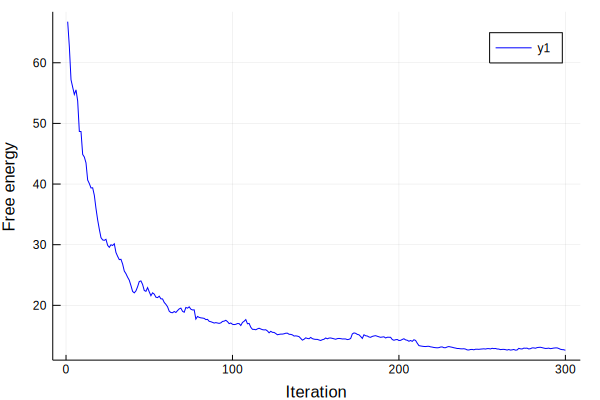

In [15]:
plot(collect(1:num_epochs*N),free_energy_list, color="blue")
xlabel!("Iteration")
ylabel!("Free energy")

In [16]:
y_predict = Dict()
for i=1:N
    z_i = transpose(a_t)*x_dict[i]
    p_i = 1.0/(1.0 + exp(-1*z_i))
    y_i = round(p_i)
    get!(y_predict, i, y_i)
end

In [17]:
correct_predict = 0.0
for i=1:N
    if y_predict[i] == y_dict[i]
        correct_predict += 1
    end
end
accuracy = correct_predict/N

0.96

In [18]:
x1_array = collect(-6.:0.01:6.)
anim = @animate for i=1:num_epochs*N
    s = plot()
    for j=1:N
        z_j = transpose(a_t_dict[i])*x_dict[j]
        p_j = 1.0/(1.0 + exp(-1*z_j))
        y_j = round(p_j)
        if y_j == 0
            scatter!([x_dict[j][1]],[x_dict[j][2]],color="blue",leg=false)
        else
            scatter!([x_dict[j][1]],[x_dict[j][2]],color="red",leg=false)
        end
    end
    x2_array = -1*a_t_dict[i][1]*x1_array./a_t_dict[i][2];
    x2_array_uncertain_1 = -1*(a_t_dict[i][1]+b_t_dict[i][1])*x1_array./(a_t_dict[i][2]-b_t_dict[i][4]);
    x2_array_uncertain_2 = -1*(a_t_dict[i][1]-b_t_dict[i][1])*x1_array./(a_t_dict[i][2]+b_t_dict[i][4]);
    plot!(x1_array,x2_array,color="green", lw=3, xlims=(-6,6), ylims=(-3,3), title="i=$(i)", label="Decision boundry")
    plot!(x1_array,x2_array_uncertain_1,color="black", lw=2, linestyle = :dash)
    plot!(x1_array,x2_array_uncertain_2,color="black", lw=2, linestyle = :dash)
end
gif(anim, "slope_change.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/sakbayrak/Codes/Semih-EUSIPCO-2019/slope_change.gif
└ @ Plots /Users/sakbayrak/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/sakbayrak/Codes/Semih-EUSIPCO-2019/slope_change.gif")

In [23]:
anim = @animate for i = 0:num_epochs*N
    s = plot(leg=false)
    p(x, y) = pdf(MvNormal(a_t_dict[i],b_t_dict[i]),[x; y])
    contour!(collect(a_t_dict[i][1]-5:0.2:a_t_dict[i][1]+5),collect(a_t_dict[i][2]-5:0.2:a_t_dict[i][2]+5),p,nlevels=3)
    scatter!([a_t_dict[i][1]],[a_t_dict[i][2]], xlims=(-4,4), ylims=(-4,4))
    title!("Change of variational mean and variance for weights")
    xlabel!("w1")
    ylabel!("w2")
end
gif(anim, "change_variational_mean.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/sakbayrak/Codes/Semih-EUSIPCO-2019/change_variational_mean.gif
└ @ Plots /Users/sakbayrak/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/sakbayrak/Codes/Semih-EUSIPCO-2019/change_variational_mean.gif")

In [24]:
anim = @animate for i = 0:num_epochs*N
    s = plot(leg=false)
    histogram2d(rand(Normal(a_t_dict[i][1],b_t_dict[i][1]),10000),rand(Normal(a_t_dict[i][2],b_t_dict[i][4]),10000),nbins=100,xlims=(-10,10), ylims=(-10,10))
    title!("Change of variational mean and variance for weights")
    xlabel!("w1")
    ylabel!("w2")
end
gif(anim, "change_variational_sample.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/sakbayrak/Codes/Semih-EUSIPCO-2019/change_variational_sample.gif
└ @ Plots /Users/sakbayrak/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/sakbayrak/Codes/Semih-EUSIPCO-2019/change_variational_sample.gif")